In [1]:
import time
import copy
import sys
from collections import OrderedDict
from collections import namedtuple
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random 
import pickle
from collections import defaultdict
import math

In [2]:
#Configure GPU (change if not M1 mac)
mps = torch.device("mps")

In [3]:
# Datasets

# Using CIFAR-10 again as in the programming assignments
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Saving And helpers

def save_tracker(tracker, path):
  np.savetxt(path, tracker, delimiter=',') 

def save_trackers(device, filename):
  """Save all trackers and current total_time to a file."""
  torch.save((device['train_loss_tracker'], device['train_acc_tracker'], device['test_loss_tracker'], device['test_acc_tracker'], total_time), filename)
  print("Saved trackers to " + filename)

def moving_average(a, n=100):
  '''Helper function used for visualization'''
  ret = torch.cumsum(torch.Tensor(a), 0)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

# Plotting helpers! 
def make_plot(trackers, num_epochs, title, y_axis_lab, should_average=False, legend=True, fix_ax=True):
  avg_fn = moving_average if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  if fix_ax:
    ax.set_ylim([0, 100])
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)

  if legend:
    _ = plt.legend()
  plt.show()

def make_plot_better(trackers, num_epochs, title, y_axis_lab, should_average=False, n = 100):
  avg_fn = (lambda x : moving_average(x, n)) if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)
  _ = plt.legend()
  plt.show()

In [5]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentalge of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''
    total_samples = len(dataset)
    sampled = {}
    number_samples = int((data_pct)*(total_samples)) 

    for i in range(num_devices):
      sampled[i] = random.sample(range(total_samples), number_samples)
        
    return sampled

In [6]:
# Neural net definitions

# Same ConvNet as in Assignment 2 and 3
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

In [7]:
# Federated learning helpers

# The baseline `average' function. 
def average_weights(devices,*args, **kwargs):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
#     max_magnitude = 0
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
      w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
#             max_magnitude = max(max_magnitude, abs(torch.max(state_dicts[i][k].type(torch.float32))))
            w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg


def get_devices_for_round(devices, device_pct):  
    return random.sample(devices, int(device_pct * len(devices)))

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }

In [8]:
# Local device training and testing
def train(epoch, device, criterion):
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.to(mps), targets.to(mps)
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device, criterion, testloader = testloader):
    device['net'].eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(mps), targets.to(mps)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)



In [9]:
# Aggregation function tests (the main experiment routine)

# Given two different sets of aggregated weights, 
# gives a value representing the difference between them,
# as a way to measure the direct cost of using our aggregated function
def diff_aggregated_weights(strat, baseline):
    result = 0 
    for k in strat.keys():
        result += torch.linalg.norm(strat[k] - baseline[k])
    return result

# A data type for experiment results
BackdoorResult = namedtuple("BackdoorResult", ["scheme_loss", "test_accuracy", "backdoor_success", "devices", "avg_weight_history"])


def run_federated_test(agg_fn = average_weights,  # Pass in aggregation function, 
                                                  #     device list -> aggregated weights 
                       rounds = 10,               # Rounds of FL
                       local_epochs = 4,          # Epochs per device                      
                       num_devices = 50,          # Total # devices
                       device_pct = 0.2,          # % of devices per round
                       data_pct = 0.1,            # % of data each device gets
                       net = ConvNet().to(mps),   # Network object; make sure on mps backend
                       evil_round = None,         # integer list option; attacker will mount attack during these rounds
                       attacker_strategy = None,  # device -> void; Sets up attacker weight update on device 
                       evil_device_id = None,     # Which device id should perform the attack
                       evaluate_attack = None,    # Evaluated on the set of devices after each round and logged.
                       output_filename = None,    # Write results to disk at this path
                       snapshot = True,           # Snapshot to disk after each round
                       resume_from_snap = None,   # Optionally resume from a prior snapshot.
                       multiple_attack_rounds = []):   
    '''
    Returns instance of BackdoorResult, with following state: 
        scheme_loss        : difference between a straight average and aggregated weights after each round
        test_accuracy      : classification accuracy after each round
        backdoor_success   : result of evaluate_attack(devices) after each round
        devices            : snapshot of devices after each round
        avg_weight_history : snapshot of central server weights after each round
    '''
    
    def lighten_device(d):
        return {
            k: d[k] for k in ( 'id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker')
        }                                   
    
    criterion = nn.CrossEntropyLoss()
    data_idxs = iid_sampler(trainset, num_devices, data_pct)

    devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]
    
    scheme_loss = []
#     max_magnitudes = []
    avg_weight_history = []
    _starting_round_num = 0
    
    if resume_from_snap: 
        print("Resuming from snapshot!\n")
        # Load what we can
        result = resume_from_snap
        scheme_loss = result.scheme_loss
        avg_weight_history = result.avg_weight_history
        partial_devices = result.devices

        # Fresh data and devices
        criterion = nn.CrossEntropyLoss()
        data_idxs = iid_sampler(trainset, num_devices, data_pct)

        devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]

        # Restore the devices with the info from the trackers
        def restore_device(old_device, new_device):
            for k in ('id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker'):
                new_device[k] = old_device[k]
            return new_device
        
        print("Restoring devices\n")
        devices = [restore_device(partial_devices[i], devices[i]) for i in range(len(devices))]
        for device in devices:
            device['net'].load_state_dict(avg_weight_history[-1])
        
        _starting_round_num = len(result.test_accuracy)
        print("Finished restoring\n")


        
    ## IID Federated Learning
    start_time = time.time()
    for round_num in range(_starting_round_num, rounds):
        round_start_time = time.time()
        # Part 1.3: Implement getting devices for each round here
        round_devices = get_devices_for_round(devices, device_pct)

        print('Round: ', round_num)
        # Train locally 
        for device in round_devices:
            for local_epoch in range(local_epochs):
                train(local_epoch, device, criterion)
        
        # One device becomes evil if required
        if ((evil_round and round_num == evil_round) or round_num in multiple_attack_rounds):
            assert (evil_device_id is not None)
            assert (attacker_strategy is not None)
            print("Attacking!\n")
            
            attacker_strategy(devices[evil_device_id])
            # Make sure evil guy gets averaged in 
            if evil_device_id not in round_devices:
                round_devices.append(devices[evil_device_id])
            print("Finished attacking\n")
            
        
        # Weight averaging
        w_baseline = average_weights(round_devices)
        w_avg = agg_fn(round_devices, (avg_weight_history[-1] if avg_weight_history != [] else None))
#         max_magnitudes.append(max_magnitude)
        
        # Track the difference between the two; should be 0 if straight average
        scheme_loss.append((float(diff_aggregated_weights(w_avg, w_baseline))))
        
        avg_weight_history.append(copy.deepcopy(w_avg))
        
        # Gradients         
        for device in devices:
            device['net'].load_state_dict(w_avg)
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            device['scheduler'].step()

        # test accuracy after aggregation
        # device 0 is the unique device with all of the 
        # test accuracies and losses in its tracker
        test(round_num, devices[0], criterion)
        
        print(f"\nDiff: {scheme_loss[-1]}\n")
        print(f"Round time: {time.time() - start_time} \n")
        if snapshot:
            intermediate_result = BackdoorResult(
                scheme_loss = scheme_loss, 
                test_accuracy = devices[0]["test_acc_tracker"], 
                backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
                devices = [lighten_device(d) for d in devices], 
                avg_weight_history = avg_weight_history
            )


            if output_filename is not None: 
                print("Writing snapshot\n")
                with open(f"snapshot_{output_filename}", 'wb') as file: 
                    pickle.dump(intermediate_result, file)
        
    total_time = time.time() - start_time
    print('Total training time: {} seconds'.format(total_time))
    
    # Pack up everything we care about and the devices for good measure
    result = BackdoorResult(
        scheme_loss = scheme_loss, 
        test_accuracy = devices[0]["test_acc_tracker"], 
        backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
        devices = [lighten_device(d) for d in devices], 
        avg_weight_history = avg_weight_history
    )

    
    if output_filename is not None: 
        with open(output_filename, 'wb') as file: 
            print("Writing file\n")
            pickle.dump(result, file)
    
    return result


# Load output files back into memory
def load_result(filename):
    with open(filename, 'rb') as file: 
        return pickle.load(file)

In [10]:
# Example usage
# results = run_federated_test(local_epochs=1, num_devices = 10, rounds = 2, output_filename = "testout.pickle")

In [11]:
# # Can also load it back
# results = load_result("snapshot_testout.pickle")
# results

In [12]:
# A silly attack that just sends massive weights all of magnitude 10000
def sample_attack(device):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    weights = device["net"].state_dict().copy()
    
    for w in weights.keys():
        weights[w] = torch.full(weights[w].size(), 10000)
    
    device['net'].load_state_dict(weights)

In [13]:
# Aggregation function that squashes any weights with magnitude over 1000 (except on the first device but whatever)
def super_smart_aggregation(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights, excluding huge updates.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
        w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
            if (torch.max(state_dicts[i][k].type(torch.float32)) <= 1000): 
                w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg

In [14]:
# Example of how this works

# Here, we carry out the attack but use the ordinary average
# results_straight_avg = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 3,              
#                                          local_epochs = 1,                             
#                                          num_devices = 10,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 1,        
#                                          attacker_strategy = sample_attack,  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline_trivial_attack.pickle")  
# Observe that it absolutely destroys our model

In [15]:
# Now we do it again but with the aggregation that rejects huge updates
# results_reject_huge = run_federated_test(agg_fn = super_smart_aggregation,                    
#                                          rounds = 3,              
#                                          local_epochs = 1,                             
#                                          num_devices = 10,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 1,        
#                                          attacker_strategy = sample_attack,  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None,
#                                          output_filename = "simple_attack_and_defense.pickle")  

In [16]:
# Here, we compute a real baseline over 100 epochs and typical averaging. Good starting point for future 
# tests; can resume from this snapshot.
# baseline = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 100,              
#                                          local_epochs = 4,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline.pickle")  

In [17]:
# baseline = load_result("baseline.pickle")

In [18]:
# For example, now can get things like
# baseline.test_accuracy

In [19]:
# We can resume from a snapshot:
# NOTE : keep all the basic params (local epochs, num devices, net, etc) the same
# when resuming from a snapshot 
# baseline2 = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 101,              
#                                          local_epochs = 4,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline2.pickle", 
#                                          resume_from_snap = baseline )  # we pass in a results object here

In [20]:
# baseline2_loaded = load_result("baseline2.pickle")
# baseline2

In [21]:
# Now we can move on to a real defense. 

# We create factory functions that let us parametrize a double sigmoid using threshholds

def torch_scaled_sigmoid_factory(a, c = 0.005, left = False):
    
    def f(x):
        scaled = torch.sub(x, a)

        divisor = c if left else -1*c

        scaled = torch.div(scaled, divisor)

        return torch.sigmoid(scaled)
    return f

def torch_double_sigmoid_factory(a,b,c = 0.005):
    left = torch_scaled_sigmoid_factory(a, left = True)
    right = torch_scaled_sigmoid_factory(b, left = False) 
    def f(x):
        return (left(x)*right(x))
    return f

my_sigmoid = torch_double_sigmoid_factory(-1,1)

In [22]:
# torch_double_sigmoid_factory(-1,6)(torch.tensor(list(range(-5,10))))

In [23]:
# Make sure it works
# torch_double_sigmoid_factory(-2,2)(torch.Tensor([-5,-4,-3,-2,-1.5,-1.4,1.3,-1,0,1,1.5,1.6,2,3,4]))

In [24]:
# Creates a sigmoid defense,
#     keys_to_range_mapping maps each layer name in the state dict to the sigmoid bounds for processing it
#     All other layers just get identity function-ed
# watcher = {}
def make_sigmoid_defense(keys_to_range_mapping, stickiness = 0):
    
    sigmoid_dict = defaultdict(lambda : (lambda x: 1))
    
    for k,(a,b) in keys_to_range_mapping.items():
        sigmoid_dict[k] = torch_double_sigmoid_factory(a,b)
    
    def f(devices, previous_round_weights):
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights preprocessed by sigmoid
        '''
        state_dicts = [device['net'].state_dict() for device in devices]
        # initialize w_avg to tensors from device 0
        w_avg = copy.deepcopy(state_dicts[0])
        for k in w_avg.keys():
            sig = sigmoid_dict[k]
#             prev_round_x = previous_round_weights[k].type(torch.float32) if  previous_round_weights is not None else x
            w_avg[k] = w_avg[k].type(torch.float32)
#             for i in range(stickiness):
#                 w_avg[k] += x              

        # for each model param
        for k in w_avg.keys():
            sig = sigmoid_dict[k]
            # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
            for i in range(1, len(devices)):
                new_weight = (state_dicts[i][k].type(torch.float32))
                prev_round_x = previous_round_weights[k].type(torch.float32)  if (previous_round_weights is not None) else new_weight
#                 if i == 1:
#                     watcher[k] = (new_weight - prev_round_x)
#                 print((())))
#                 print((len(new_weight)))


                w_avg[k] += new_weight*(sig(torch.sub(new_weight, prev_round_x)))
            # compute average
            w_avg[k] /= float(len(devices) + stickiness)
        return w_avg
    

    
    
    return f

In [25]:
# These are the actual layer weights that we care about
[x for x in baseline.avg_weight_history[-1].keys() if '.0.weight' in x]

NameError: name 'baseline' is not defined

In [26]:
# Now lets set up a potential sigmoid defense
# empirical_cutoffs = {
#     'model.0.0.weight' : (-2,2),
#     'model.1.0.weight' : (-2,2),
#     'model.2.0.weight' : (-.7,.7),
#     'model.3.0.weight' : (-.6,.6),
#     'model.4.0.weight' : (-0.7,0.7),
#     'model.5.0.weight' : (-0.5,0.5),
#     'model.6.0.weight' : (-0.3,0.3),
#     'model.7.0.weight' : (-0.2,0.2),
#     'model.8.0.weight' : (-0.2,0.2),
# }
empirical_cutoffs = {
    'model.0.0.weight' : (-0.3,0.3),
    'model.1.0.weight' : (-0.3,0.3),
    'model.2.0.weight' : (-0.3,0.3),
    'model.3.0.weight' : (-0.3,0.3),
    'model.4.0.weight' : (-0.3,0.3),
    'model.5.0.weight' : (-0.3,0.3),
    'model.6.0.weight' : (-0.3,0.3),
    'model.7.0.weight' : (-0.1,0.1),
    'model.8.0.weight' : (-0.1,0.1),
}
sigmoid_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0)

In [27]:
# sigmoid_resumption = run_federated_test(agg_fn = sigmoid_accuracy,                    
#                                          rounds = 110,              
#                                          local_epochs = 1,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.05,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = None,
#                                          snapshot = False,
#                                          resume_from_snap = baseline )  # we pass in a results object here

In [28]:
# Now lets make an attack
# Makes an attack that puts noise in all of target layers. 
# Noise is uniform over a,b
def noise_attack_factory(target_layers, a,b):
    def attack(device):
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights.
        '''
        weights = device["net"].state_dict().copy()

        for w in weights.keys():
            if w in target_layers:
                weights[w] = (a - b) * torch.rand(weights[w].size()) + b

        device['net'].load_state_dict(weights)
    return attack

In [29]:
# We attack these layers with weights ranging from -4,4
target_layers = ['model.0.0.weight',
 'model.1.0.weight',
 'model.2.0.weight',
 'model.3.0.weight',
 'model.4.0.weight',
 'model.5.0.weight',
 'model.6.0.weight',
 'model.7.0.weight',
 'model.8.0.weight']
big_noise_attack = noise_attack_factory(target_layers,-3,3)

In [30]:
# We'll resume from our baseline model


In [31]:
# baseline = load_result("baseline.pickle")
# determine_cutoffs = run_federated_test( agg_fn = sigmoid_aggregation,                    
#                                          rounds = 101, # go 30 pounds past where the baseline left off              
#                                          local_epochs = 0,        # all else the same                     
#                                          num_devices = 50,         
#                                          device_pct = 0.05,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = None, # attack after 10 rounds more training with the new acc fn        
#                                          attacker_strategy = None, # device 2 will carry out big noise attack  
#                                          evil_device_id = None,     
#                                          evaluate_attack = None, # we will evaluate manually afterwards 
#                                          output_filename = None,
#                                          resume_from_snap = baseline, #pick up where baseline left off  
#                                          snapshot = False ) # 

In [32]:
# watcher

In [33]:
# def make_sigmoid_on_cutoff(a,c=0.005, left = False):
#     def f(x):
#         if(not left and x > (a + 2)):
#             return 0
#         if(left and x < (a - 2)):
#             return 0
#         exponent = (-(x-a))/(c if left else -1*c)
#         return 1/(1 + (math.e**(exponent)))
#     return f 

# def make_double_sigmoid(a,b):
#     left = make_sigmoid_on_cutoff(a, left = True)
#     right = make_sigmoid_on_cutoff(b, left = False)
#     def f(x):
#         return left(x)*right(x)
#     return f
# baseline2.devices[0]['net']

def make_test_device(trainset):
    data_idxs = iid_sampler(trainset, 1, .1)
    return create_device(ConvNet().to(mps), 0, trainset, data_idxs[0]) 



In [34]:
# 


In [35]:
# big_noise_attack(device)

In [36]:
# device['net'].state_dict()['model.0.0.weight']

In [37]:
# trainset[1]

In [38]:
# labels = [x[1] for x in trainset if x[1] == 1]

In [39]:
# len(labels)

In [40]:
def swap_classes_dataset(s, a, b):
    s = list(s)
    for i in range(len(s)):
        if s[i][1] == a:
            s[i] = s[i][0],b
        elif s[i][1] == b:
            s[i] = s[i][0],a 
    
    return s

def limit_test_set(s, labels):
    s = list(s)
    s = [s for s in s if s[1] in labels]
    return s


# Make switch classes attack
def switch_classes_attack(a,b, train_epochs):
    transform_train = transforms.Compose([                                   
        transforms.RandomCrop(32, padding=4),                                       
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    evil_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                            download=True,
                                            transform=transform_train)
    print(len(evil_trainset))


#     evil_trainset = limit_test_set(evil_trainset, [a,b])
    evil_trainset = swap_classes_dataset(evil_trainset, a,b)
    print(len(evil_trainset))


    print("swapping and limiting\n")
    
    # Load testing data
    transform_test = transforms.Compose([                                           
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    
    evil_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True,
                                           transform=transform_test)
    evil_testset = limit_test_set(evil_testset, [a,b])

    
    evil_testset = swap_classes_dataset(evil_testset, a,b)
    
    evil_testloader = torch.utils.data.DataLoader(evil_testset, batch_size=128, shuffle=False)
    
    attack_idx = iid_sampler(evil_trainset, 1, 1)[0]
    
    
    
    evil_device_trainset = DatasetSplit(evil_trainset, attack_idx)
    evil_device_trainloader = torch.utils.data.DataLoader(evil_device_trainset,
                                                     batch_size=128,
                                                     shuffle=True)

    criterion = nn.CrossEntropyLoss()
    
    logged_state_dict = None

    class attack_class:
        def __init__(self):
            self.logged_state_dict = None
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights.
        '''
        def __call__(self, device):
            device['dataloader'] = evil_device_trainloader

            if self.logged_state_dict is not None:
                print("Using memoized attack\n")
                device['net'].load_state_dict(self.logged_state_dict)
            else:
                for local_epoch in range(train_epochs):
                    train(local_epoch, device, criterion)
                    test(0, device, criterion,testloader =  evil_testloader)


            print("Confirm the attack worked. (This should be high)")  
            test(0, device, criterion,testloader =  evil_testloader)


            self.logged_state_dict = copy.deepcopy(device['net'].state_dict())

        

    return attack_class()

In [59]:
# Now let's make an instance of this attack that performs 25 epochs of training on the evil device with the misclassified data.
# Specifically, we switch cars and airplanes
sca_01 = switch_classes_attack(0,1,25)

Files already downloaded and verified
50000
50000
swapping and limiting

Files already downloaded and verified


In [60]:
# baseline = load_result("baseline.pickle")
# switch_classes_no_defense = run_federated_test(                    
#                                          rounds = 130, # go 30 pounds past where the baseline left off              
#                                          local_epochs = 4,        # all else the same                     
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 110, # attack after 10 rounds more training with the new acc fn        
#                                          attacker_strategy = sca2, # device 2 will carry out big noise attack  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None, # we will evaluate manually afterwards 
#                                          output_filename = "switch_classes_no_defense.pickle",
#                                          resume_from_snap = baseline, #pick up where baseline left off  
#                                          snapshot = True ) # 

In [61]:
# switch_classes_no_defense = load_result("switch_classes_no_defense.pickle")

In [62]:
# switch_classes_no_defense.test_accuracy

In [63]:

# def test(epoch, device, criterion, testloader = testloader):

In [65]:
# test(0, test_device, nn.CrossEntropyLoss(), testloader)

In [41]:
def limit_test_set(s, labels):
    s = list(s)
    s = [s for s in s if s[1] in labels]
    return s



def make_testloader_subset(labels, a, b):
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
    
    restricted_test_set = limit_test_set(testset, labels)
#     print(len(restricted_test_set))
    restricted_test_set = swap_classes_dataset(restricted_test_set, a, b)
    
    restricted_testloader = torch.utils.data.DataLoader(restricted_test_set, batch_size=128, shuffle=False)
    
    return restricted_testloader

In [42]:
# [x[1] for x in checker_test_set]

In [43]:
# test(0, test_device, nn.CrossEntropyLoss(), checker_test_set)

In [44]:
def weight_history_to_layer_max_magnitude_and_means(w_avg, include_batch_norm = True):
    weight_keys = [x for x in w_avg.keys() if ".0.weight" in x]
    if include_batch_norm:
        weight_keys += [x for x in w_avg.keys() if ".1.weight" in x]
    def max_magnitude(t):
        return torch.max(torch.abs(t))
    def mean_magnitude(t):
        return torch.mean(torch.abs(t))
    all_means = [mean_magnitude(w_avg[w]) for w in weight_keys]
    all_max = [max_magnitude(w_avg[w]) for w in weight_keys]
    return all_means, all_max
max_history = [weight_history_to_layer_max_magnitude_and_means(baseline.avg_weight_history[t], include_batch_norm = False) for t in range(100)]
max_history = [x[1] for x in max_history]
by_layer = [[max_history[k][l].cpu() for k in range(len(max_history))] for l in range(len(max_history[0]))]

[plt.plot([x for x in range(100)],by_layer[l],  '-k', color='blue') for l in range(9)]

NameError: name 'baseline' is not defined

In [45]:
# watcher

In [46]:
# max_history = [weight_history_to_layer_max_magnitude_and_means(watcher, include_batch_norm = False) for t in range(1)]
# max_history = [(x[1]) for x in max_history]
# by_layer = [[max_history[k][l].cpu() for k in range(len(max_history))] for l in range(len(max_history[0]))]

# [plt.plot([x for x in range(1)],by_layer[l],  '-k', color=['blue','red','green','blue', 'red', 'green', 'blue', 'red', 'green'][l]) for l in range(5,6)]

In [47]:
# max_history

In [146]:
baseline = load_result("baseline.pickle")
sigmoid_against_noise_attack = run_federated_test(agg_fn = sigmoid_aggregation,                    
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = big_noise_attack, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "sigmoid_against_noise_attack_final.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True)  

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
(Device 34/Epoch 3) Train Loss: 0.353 | Train Acc: 88.640 | Test Loss: 0.403 | Test Acc: 86.770

Diff: 0.21199172735214233

Round time: 338.0134241580963 

Writing snapshot

Round:  101
(Device 49/Epoch 3) Train Loss: 0.347 | Train Acc: 88.020 | Test Loss: 0.381 | Test Acc: 87.730

Diff: 2.324102933926042e-05

Round time: 662.2266662120819 

Writing snapshot

Round:  102
(Device 2/Epoch 3) Train Loss: 0.240 | Train Acc: 91.2600 | Test Loss: 0.387 | Test Acc: 87.700

Diff: 7.141364767448977e-05

Round time: 984.8954751491547 

Writing snapshot

Round:  103
(Device 3/Epoch 3) Train Loss: 0.303 | Train Acc: 89.3000 | Test Loss: 0.378 | Test Acc: 87.960

Diff: 2.7878273613168858e-05

Round time: 1270.7090492248535 

Writing snapshot

Round:  104
(Device 16/Epoch 3) Train Loss: 0.387 | Train Acc: 87.040 | Test Loss: 0.386 | Test Acc: 87.480

Diff: 0.00034004563349299133

Round time: 1559.5193321704865 

Writing snap

In [147]:
sca_zero_one = switch_classes_attack(0,1,25)
baseline = load_result("baseline.pickle")
switch_classes_no_defense = run_federated_test(                    
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_no_defense_multiple_final.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109]) # 

Files already downloaded and verified
swapping

Files already downloaded and verified
Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
(Device 44/Epoch 3) Train Loss: 0.285 | Train Acc: 90.480Attacking!

(Device 2/Epoch 24) Train Loss: 0.014 | Train Acc: 99.5660Confirm the attack worked. (This should be high)
 | Test Loss: 0.963 | Test Acc: 85.330
Finished attacking

 | Test Loss: 0.411 | Test Acc: 86.850

Diff: 0.0

Round time: 1250.4205939769745 

Writing snapshot

Round:  101
(Device 15/Epoch 3) Train Loss: 0.311 | Train Acc: 89.640Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 1.255 | Test Acc: 78.250
Finished attacking

 | Test Loss: 0.404 | Test Acc: 86.880

Diff: 0.0

Round time: 1435.8249740600586 

Writing snapshot

Round:  102
(Device 39/Epoch 3) Train Loss: 0.269 | Train Acc: 90.700Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 1.810 | Test Acc: 78

In [148]:
sca_zero_one_2 = switch_classes_attack(0,1,25)
baseline = load_result("baseline.pickle")
switch_classes_sigmoid_defense = run_federated_test(  agg_fn = sigmoid_aggregation, 
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one_2, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_sigmoid_defense_multiple_final.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109]) # 

Files already downloaded and verified
swapping

Files already downloaded and verified
Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
(Device 7/Epoch 3) Train Loss: 0.354 | Train Acc: 88.2400Attacking!

(Device 2/Epoch 24) Train Loss: 0.019 | Train Acc: 99.3360Confirm the attack worked. (This should be high)
 | Test Loss: 0.802 | Test Acc: 86.410
Finished attacking

 | Test Loss: 0.539 | Test Acc: 82.430

Diff: 10.120282173156738

Round time: 1260.700845003128 

Writing snapshot

Round:  101
(Device 10/Epoch 3) Train Loss: 0.304 | Train Acc: 90.080Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.646 | Test Acc: 84.470
Finished attacking

 | Test Loss: 0.394 | Test Acc: 88.150

Diff: 1.0120688676834106

Round time: 1605.5601961612701 

Writing snapshot

Round:  102
(Device 9/Epoch 3) Train Loss: 0.250 | Train Acc: 91.8800Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Te

In [149]:
switch_classes_no_defense.avg_weight_history[-1]

OrderedDict([('model.0.0.weight',
              tensor([[[[ 7.4600e-01,  8.4820e-01,  4.7823e-01],
                        [ 5.1573e-01,  1.0049e+00,  1.2566e+00],
                        [-5.9251e-01, -3.1604e-01, -1.8427e-01]],
              
                       [[-5.3358e-01, -8.8284e-01, -5.9071e-01],
                        [-1.0610e+00, -8.9894e-01,  4.1919e-01],
                        [-1.0492e+00, -1.1256e+00, -3.9162e-01]],
              
                       [[ 1.2420e-01, -1.3487e-01,  8.3084e-04],
                        [-1.8890e-01,  3.6324e-01,  1.1430e+00],
                        [ 1.9642e-01,  6.0267e-01,  1.1399e+00]]],
              
              
                      [[[-1.9969e-01,  3.3645e-01,  3.9868e-01],
                        [-1.1443e+00, -3.7165e-01,  1.0054e+00],
                        [-9.7183e-02, -2.2539e-02,  3.8900e-01]],
              
                       [[-4.9338e-01, -3.5729e-01,  2.5315e-01],
                        [-1.0529e+00, -6.

In [320]:
# sca_zero_one = switch_classes_attack(0,1,2)
baseline = load_result("baseline.pickle")
switch_classes_no_defense_fixed_2 = run_federated_test(                    
                                         rounds = 150, # go 30 pounds past where the baseline left off              
                                         local_epochs = 1,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.02,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_no_defense_multiple_final_fixed_2.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = False, 
                                         multiple_attack_rounds = (list(range(100,130)))) # 

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
(Device 43/Epoch 0) Train Loss: 0.386 | Train Acc: 87.900Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 1.508 | Test Acc: 67.450

Diff: 0.0

Round time: 19.802228927612305 

Round:  101
(Device 7/Epoch 0) Train Loss: 0.438 | Train Acc: 85.440Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 0.583 | Test Acc: 79.280

Diff: 0.0

Round time: 31.828557014465332 

Round:  102
(Device 35/Epoch 0) Train Loss: 0.374 | Train Acc: 86.840Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 0.835 | Test Acc: 69.240

Diff: 0.0

Round time: 40.55018210411072 

Round:  103
(Device 19/Epoch 0) Train Loss: 0.373 

Finished attacking

 | Test Loss: 1.011 | Test Acc: 69.810

Diff: 0.0

Round time: 322.5382959842682 

Round:  128
(Device 5/Epoch 0) Train Loss: 0.510 | Train Acc: 82.100Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 1.012 | Test Acc: 70.070

Diff: 0.0

Round time: 332.42797088623047 

Round:  129
(Device 32/Epoch 0) Train Loss: 0.513 | Train Acc: 81.520Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 1.020 | Test Acc: 69.590

Diff: 0.0

Round time: 341.52513813972473 

Round:  130
(Device 1/Epoch 0) Train Loss: 0.509 | Train Acc: 81.540 | Test Loss: 0.514 | Test Acc: 83.110

Diff: 0.0

Round time: 355.09473490715027 

Round:  131
(Device 3/Epoch 0) Train Loss: 0.382 | Train Acc: 87.240 | Test Loss: 0.463 | Test Acc: 84.640

Diff: 0.0

Round time: 369.60166001319885 

Ro

In [300]:
switch_classes_no_defense_fixed = load_result("switch_classes_no_defense_multiple_final_fixed.pickle")

<All keys matched successfully>

Files already downloaded and verified
 | Test Loss: 0.583 | Test Acc: 81.537


In [317]:
empirical_cutoffs = {
    'model.0.0.weight' : (-0.01,0.01),
    'model.1.0.weight' : (-0.01,0.01),
    'model.2.0.weight' : (-0.01,0.01),
    'model.3.0.weight' : (-0.01,0.01),
    'model.4.0.weight' : (-0.01,0.01),
    'model.5.0.weight' : (-0.01,0.01),
    'model.6.0.weight' : (-0.01,0.01),
    'model.7.0.weight' : (-0.01,0.01),
    'model.8.0.weight' : (-0.01,0.01),
}
all_keys   = [x for x in baseline.avg_weight_history[-1].keys() if ".weight" in x]
test_cutoffs = {
    x : (-0.01,0.01)
    for x in all_keys
}

sigmoid_aggregation = make_sigmoid_defense(test_cutoffs, stickiness=0)

# sca_zero_one = switch_classes_attack(0,1,2)
baseline = load_result("baseline.pickle")
switch_classes_sigmoid_defense_fixed = run_federated_test(  agg_fn=sigmoid_aggregation,                
                                         rounds = 150, # go 30 pounds past where the baseline left off              
                                         local_epochs = 0,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.4,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_sigmoid_defense_multiple_final_fixed.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = False, 
                                         multiple_attack_rounds = (list(range(100,130)))) # 

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 3.217 | Test Acc: 10.000

Diff: 61.552120208740234

Round time: 10.591506958007812 

Round:  101
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 2.378 | Test Acc: 10.000

Diff: 51.3704948425293

Round time: 17.99462580680847 

Round:  102
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 2.349 | Test Acc: 10.000

Diff: 42.18416213989258

Round time: 25.071220874786377 

Round:  103
Attacking!

Using memoized attack

Confirm the attack worked. (This should be high)
 | Test Loss: 0.272 | Test Acc: 91.250
Finished attacking

 | Test Loss: 2.341 | T

 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.12388928979635239

Round time: 529.5668148994446 

Round:  136
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.09750255942344666

Round time: 535.0100967884064 

Round:  137
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.07673581689596176

Round time: 541.0797357559204 

Round:  138
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.060392115265131

Round time: 548.1955320835114 

Round:  139
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.04752938821911812

Round time: 554.9258449077606 

Round:  140
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.03740628808736801

Round time: 560.588574886322 

Round:  141
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.02943924255669117

Round time: 566.3499519824982 

Round:  142
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.02316909097135067

Round time: 572.1516077518463 

Round:  143
 | Test Loss: 2.340 | Test Acc: 10.000

Diff: 0.018234383314847946

Round time: 577.8510336875916 

Round:  144
 | 

In [49]:
def make_evaluate_switch_classes_attack_weights(a, b):
    checker_test_set_nontarget = make_testloader_subset([x for x in list(range(10)) if x not in [a,b]], 0, 0)
    checker_test_set_target = make_testloader_subset([a,b], a, b)
    
    def f(w):
        test_device = make_test_device(trainset)
        test_device['net'].load_state_dict(w)

        test(0, test_device, nn.CrossEntropyLoss(), checker_test_set_nontarget)
        nontarget_accuracy = test_device['test_acc_tracker'][-1]
        test(0, test_device, nn.CrossEntropyLoss(), checker_test_set_target)
        target_accuracy = test_device['test_acc_tracker'][-1]
        return nontarget_accuracy, target_accuracy
    return f 

In [51]:
no_defense_switch_classes = load_result("switch_classes_no_defense_multiple_final_fixed_2.pickle")
evaluate_switch_classes_attack_weights = make_evaluate_switch_classes_attack_weights(0,1)
d = [evaluate_switch_classes_attack_weights(no_defense_switch_classes.avg_weight_history[r]) for r in range(len(no_defense_switch_classes.avg_weight_history))]

Files already downloaded and verified
Files already downloaded and verified
 | Test Loss: 2.495 | Test Acc: 12.750
 | Test Loss: 4.315 | Test Acc: 0.000
 | Test Loss: 1.529 | Test Acc: 43.112
 | Test Loss: 3.896 | Test Acc: 1.750
 | Test Loss: 1.215 | Test Acc: 56.038
 | Test Loss: 4.935 | Test Acc: 1.600
 | Test Loss: 1.095 | Test Acc: 60.550
 | Test Loss: 5.553 | Test Acc: 2.300
 | Test Loss: 1.050 | Test Acc: 62.237
 | Test Loss: 6.340 | Test Acc: 2.600
 | Test Loss: 0.918 | Test Acc: 66.938
 | Test Loss: 6.901 | Test Acc: 1.850
 | Test Loss: 0.874 | Test Acc: 69.225
 | Test Loss: 7.538 | Test Acc: 1.900
 | Test Loss: 0.765 | Test Acc: 72.787
 | Test Loss: 8.150 | Test Acc: 1.400
 | Test Loss: 0.732 | Test Acc: 74.875
 | Test Loss: 8.904 | Test Acc: 1.350
 | Test Loss: 0.704 | Test Acc: 75.537
 | Test Loss: 9.064 | Test Acc: 1.100
 | Test Loss: 0.641 | Test Acc: 78.325
 | Test Loss: 9.676 | Test Acc: 0.850
 | Test Loss: 0.633 | Test Acc: 78.588
 | Test Loss: 9.873 | Test Acc: 1.000


 | Test Loss: 1.284 | Test Acc: 42.000
 | Test Loss: 0.442 | Test Acc: 85.088
 | Test Loss: 1.955 | Test Acc: 35.800
 | Test Loss: 0.541 | Test Acc: 83.075
 | Test Loss: 1.814 | Test Acc: 35.650
 | Test Loss: 0.439 | Test Acc: 85.575
 | Test Loss: 1.428 | Test Acc: 39.700
 | Test Loss: 0.478 | Test Acc: 84.213
 | Test Loss: 2.273 | Test Acc: 31.450
 | Test Loss: 0.519 | Test Acc: 83.037
 | Test Loss: 1.661 | Test Acc: 35.650
 | Test Loss: 0.506 | Test Acc: 83.975
 | Test Loss: 2.242 | Test Acc: 34.350
 | Test Loss: 0.460 | Test Acc: 84.912
 | Test Loss: 1.122 | Test Acc: 50.850
 | Test Loss: 0.484 | Test Acc: 84.037
 | Test Loss: 2.383 | Test Acc: 37.000
 | Test Loss: 0.488 | Test Acc: 84.250
 | Test Loss: 1.684 | Test Acc: 39.400
 | Test Loss: 0.466 | Test Acc: 84.500
 | Test Loss: 2.231 | Test Acc: 29.450
 | Test Loss: 0.491 | Test Acc: 84.325
 | Test Loss: 1.515 | Test Acc: 40.850
 | Test Loss: 0.471 | Test Acc: 84.612
 | Test Loss: 2.201 | Test Acc: 35.700
 | Test Loss: 0.469 | Tes

[(12.75, 0.0),
 (43.1125, 1.75),
 (56.0375, 1.6),
 (60.55, 2.3),
 (62.2375, 2.6),
 (66.9375, 1.85),
 (69.225, 1.9),
 (72.7875, 1.4),
 (74.875, 1.35),
 (75.5375, 1.1),
 (78.325, 0.85),
 (78.5875, 1.0),
 (79.9375, 0.95),
 (80.7, 0.85),
 (81.55, 0.8),
 (81.125, 0.85),
 (82.8375, 0.8),
 (83.1625, 0.75),
 (83.9625, 0.8),
 (83.9875, 0.75),
 (84.525, 0.7),
 (84.9875, 0.75),
 (84.775, 0.75),
 (85.3875, 0.65),
 (85.4875, 0.6),
 (86.075, 0.6),
 (86.25, 0.6),
 (86.2875, 0.6),
 (86.35, 0.55),
 (86.275, 0.6),
 (86.45, 0.6),
 (86.6375, 0.65),
 (86.6125, 0.7),
 (86.45, 0.6),
 (86.4625, 0.75),
 (86.65, 0.7),
 (86.5375, 0.75),
 (86.675, 0.75),
 (86.5, 0.6),
 (86.825, 0.7),
 (86.775, 0.75),
 (86.5375, 0.7),
 (86.8125, 0.65),
 (86.85, 0.8),
 (86.8125, 0.8),
 (86.7375, 0.75),
 (86.8625, 0.75),
 (86.75, 0.8),
 (86.8, 0.75),
 (87.025, 0.8),
 (87.0875, 0.8),
 (86.95, 0.8),
 (86.925, 0.8),
 (86.8125, 0.85),
 (87.0, 0.8),
 (86.925, 0.8),
 (86.825, 0.8),
 (86.9875, 0.8),
 (86.9125, 0.75),
 (86.9, 0.8),
 (87.125

In [114]:
def make_plot_better(trackers, num_epochs, title, y_axis_lab, should_average=False, n = 100, add_attack_region = None, alpha = .2):
  avg_fn = (lambda x : moving_average(x, n)) if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)
  _ = plt.legend()
  sample_tracker = list(trackers.items())[0][1]
  if add_attack_region is not None: 
      ax.fill_between(range(add_attack_region[0], add_attack_region[1]), 0, 100, alpha=alpha,  color='red')
  plt.show()

In [115]:
regular_acc = [x[0] for x in d]
other_acc = [x[1] for x in d]

In [140]:
tracks = {
    "Misclassifications (Attacked Cases)" : other_acc,   
    "Accuracy on Remaining Classes" : regular_acc
}

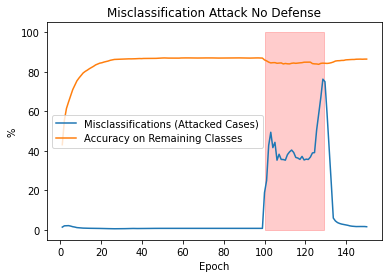

In [142]:
make_plot_better(tracks, len(other_acc), title="Misclassification Attack No Defense", y_axis_lab="%", should_average=True,  add_attack_region =(100,130), n=4)



In [118]:
sigmoid_against_noise = load_result("sigmoid_against_noise_attack_final.pickle")

In [119]:
no_defense_noise = load_result("noise_attack_1_no_defense.pickle")

In [130]:
sd = sigmoid_against_noise.test_accuracy[100:]
nd = no_defense_noise.test_accuracy[100:]
tracks2 = {
    "Sigmoid Defense" : sd,   
    "No Defense" : nd
}

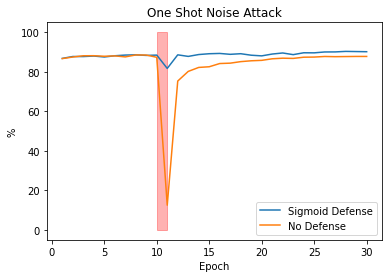

In [136]:
make_plot_better(tracks2, 30, title="One Shot Noise Attack", y_axis_lab="%", should_average=False,  add_attack_region =(10,12), n=0, alpha = .3)


